In [1]:
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

import sys
import operator

import fastparquet
import snappy

/Users/edasmalchi/anaconda3/envs/pd1/lib/python3.8/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [2]:
def showall(df):
    #shows entire dataframe
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [58]:
alldays_timestamped = pd.read_parquet('alldays_timestamped_pd1.parquet')
alldays_timestamped['Vehicle_Location'] = alldays_timestamped['Vehicle Location']
alldays_timestamped.set_index('Vehicle_Location', append=True, inplace=True)

In [ ]:
alldays_timestamped.to

In [59]:
##TODO code into viol classifier on rewrite
def reset_viol_time(df, hour=22, opr='=='):
    
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '==': operator.eq}
    
    df.sort_index(level='Timestamp', inplace=True)
    s = df.index.get_level_values(level='Timestamp')
    hr = ops[opr](s.hour, hour)
    filtered = df.loc[hr]
    filtered.loc[:, 'Violator'] = filtered.loc[:, 'Violator'].apply(lambda x: 'Likely Non-Violator' if x == 'Violator' else x)
    df = df.loc[~hr]
    df = df.append(filtered)
    return df

alldays_timestamped = reset_viol_time(alldays_timestamped)
alldays_timestamped = reset_viol_time(alldays_timestamped, hour=18, opr='<')

/Users/edasmalchi/anaconda3/envs/pd1/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [87]:
##TODO add to initial viol classifier
def add_tnc_cns(df):
    if df['CNS?']:
        df['Violator'] = df['Violator'] + ', CNS'
    elif df['TNC?']:
        df['Violator'] = df['Violator'] + ', TNC'
    return df

In [61]:
alldays_timestamped.sort_index(level='Timestamp', inplace=True)

In [63]:
%prun -l 20 time alldays_timestamped = alldays_timestamped.apply(add_tnc_cns, axis=1)

CPU times: user 9min 1s, sys: 17.4 s, total: 9min 18s
Wall time: 9min 43s
 

In [157]:
def make_plot(df, palette):
    ##make size interactive?
    def dynamic(duration_min):
        if duration_min < 2:
            return 7
        elif duration_min < 5:
            return 6
        elif duration_min < 15:
            return 5
        elif duration_min < 30:
            return 3
        elif duration_min < 60:
            return 3
        else:
            return 2
        
    #drop location from multiindex
    dropped = df.droplevel('Vehicle_Location')
    #remove locations besides spc 1-3, bike lane
    dropped = dropped[~dropped['Vehicle Location'].isin(['SB travel lane', 
                                                        'NB right turn pocket', 'Both/Middle of Space 1 & 2'])]
    #order locations
    dropped.sort_values(by=['Vehicle Location'], inplace=True)
    #create time column from index for x-axis, assign enforcement start time
    dropped['time'] = dropped.index
    start = min(dropped.index).to_pydatetime()
    end = max(dropped.index).to_pydatetime()
    enf_start = start.replace(hour=18, minute=0)
    enf_end = start.replace(hour=22, minute=0)
    duration = ((end - start).seconds) / 60
    #time range to display
    times = [min(dropped['time']), max(dropped['time'])]
    fig,ax = plt.subplots()
    #plot using Seaborn strip plot, set x-axis range, add line at enforcement start time, format x-axis...
    #hue will have to read both violator and TNC/CNS
    ax = sns.stripplot(x="time", y="Vehicle Location", hue='Violator', palette=palette, data=dropped,
                       size = dynamic(duration), jitter=False)
    ax.set_xlim(times)
    ax.axvline(enf_start, label='Loading Zone Start', c='r')
    ax.axvline(enf_end, label='Loading Zone End', c='b')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title(df['Begin Date'][0])
    fig.autofmt_xdate()
    plt.show()

In [152]:
##TODO show TNC/CNS activity on plot
def plot(df, allday_df=alldays_timestamped):
    #assign seperate colors to TNC/CNS/viol combos, pass list to plot_oneday (consistent colors...)
    unique = allday_df['Violator'].unique()
    unique.sort()
    colors = ['black', 'scarlet', 'light red', 'olive green', 'grass green', 'mint', 'brick red', 'dark orange', 'pumpkin']
    palette = dict(zip(unique, sns.xkcd_palette(colors)))
    
    make_plot(df, palette)
    
    return

In [118]:
unique1

array(['Bike Lane Blocking', 'Bike Lane Blocking, CNS',
       'Bike Lane Blocking, TNC', 'Likely Non-Violator',
       'Likely Non-Violator, CNS', 'Likely Non-Violator, TNC', 'Violator',
       'Violator, CNS'], dtype=object)

In [ ]:
plot_everything(alldays_timestamped.loc['2019-08-30 19:20:00':'2019-08-30 19:30:00'])

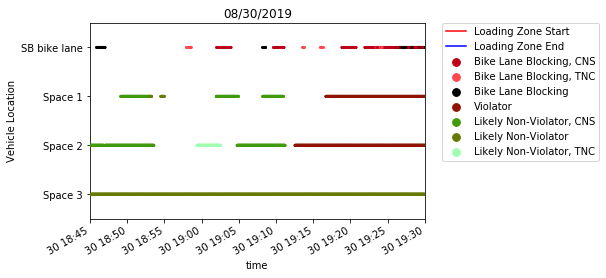

In [146]:
plot_everything(alldays_timestamped.loc['2019-08-30 18:45:00':'2019-08-30 19:30:00'])

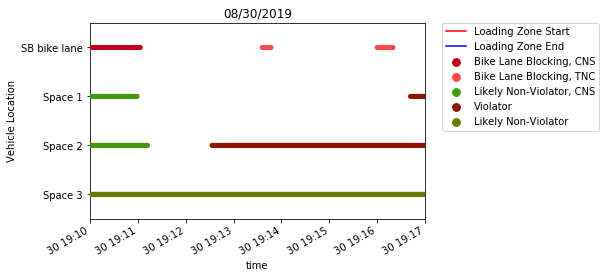

In [150]:
plot_everything(alldays_timestamped.loc['2019-08-30 19:10:00':'2019-08-30 19:17:00'])

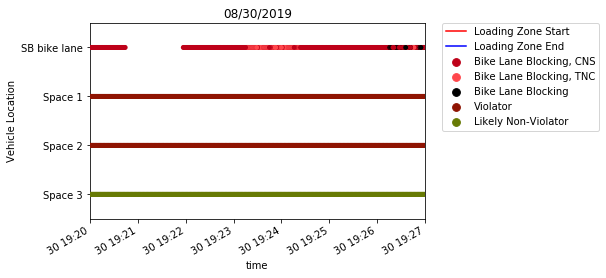

In [149]:
plot_everything(alldays_timestamped.loc['2019-08-30 19:20:00':'2019-08-30 19:27:00'])

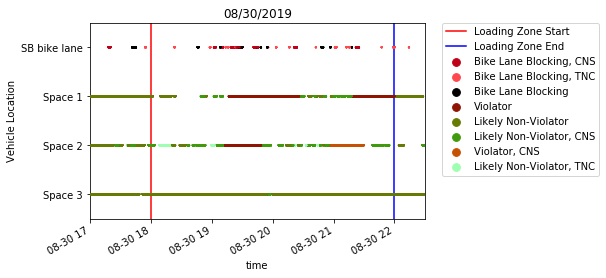

In [148]:
plot_everything(alldays_timestamped.loc['2019-08-30 17:00:00':'2019-08-30 22:30:00'])

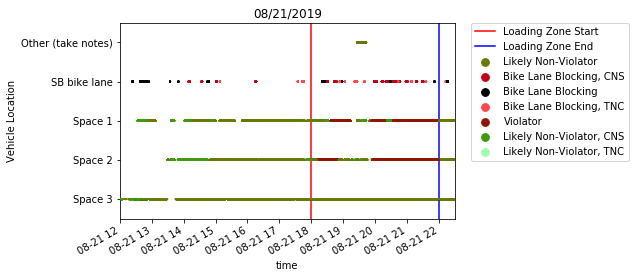

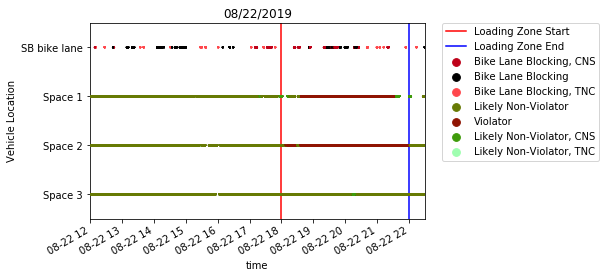

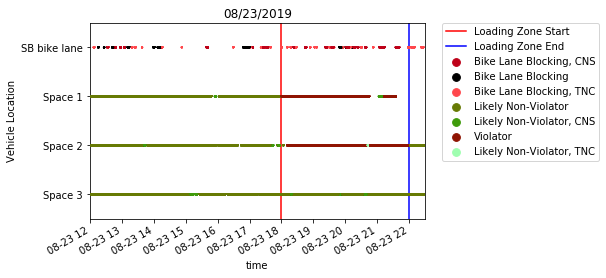

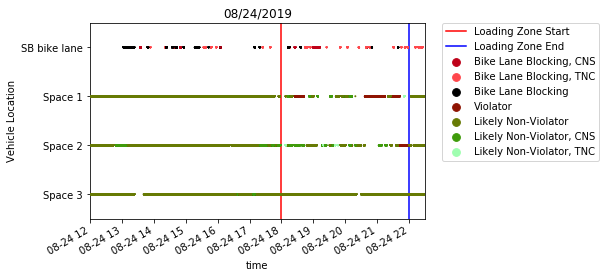

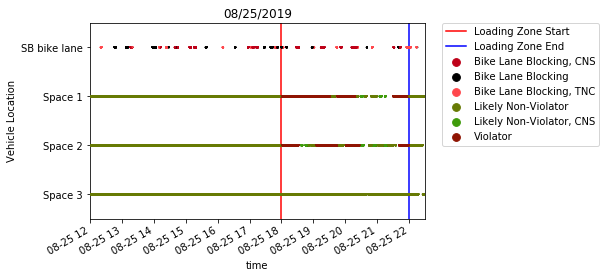

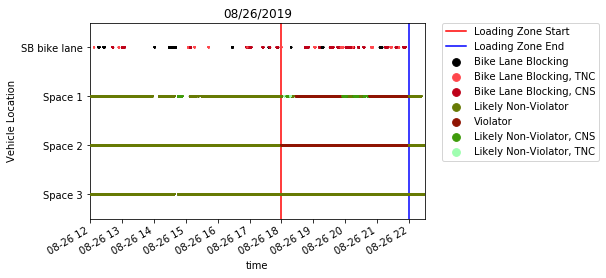

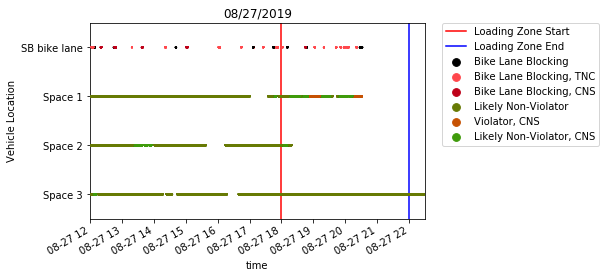

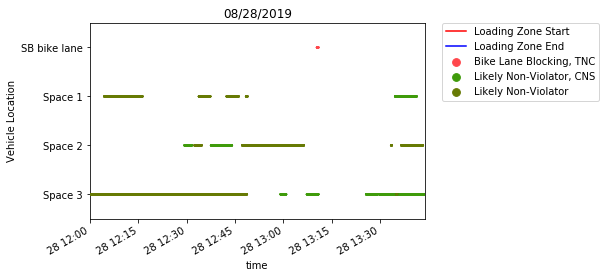

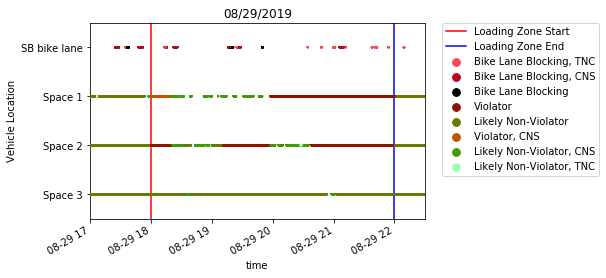

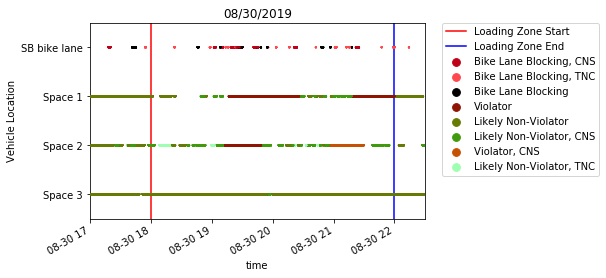

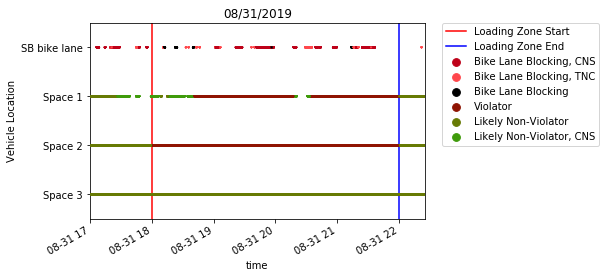

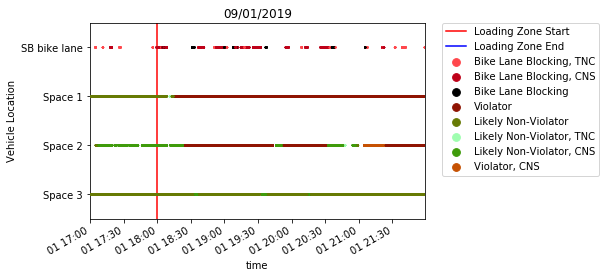

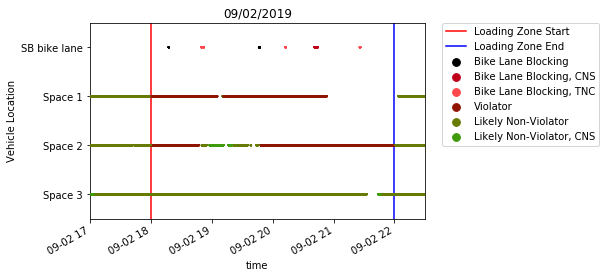

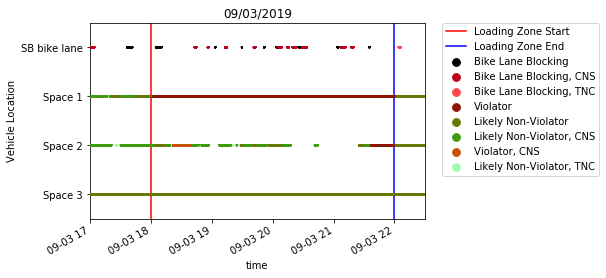

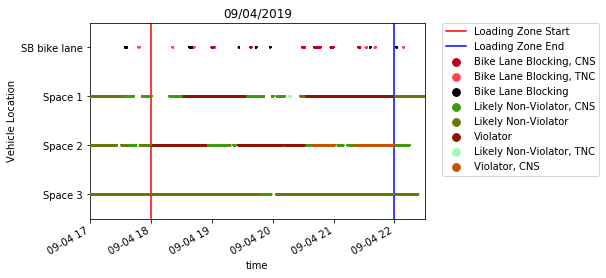

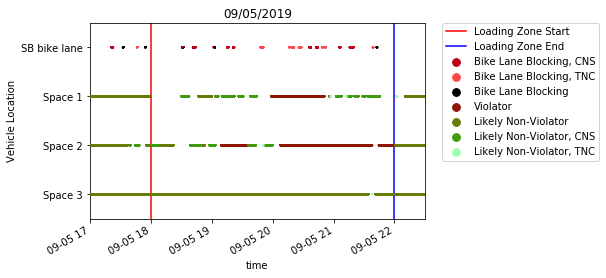

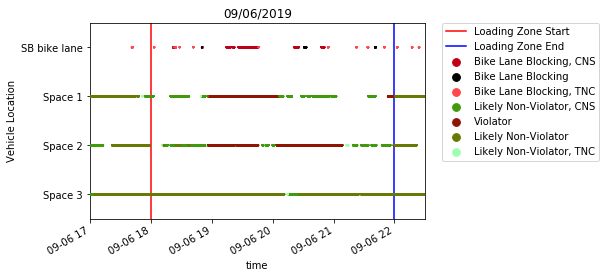

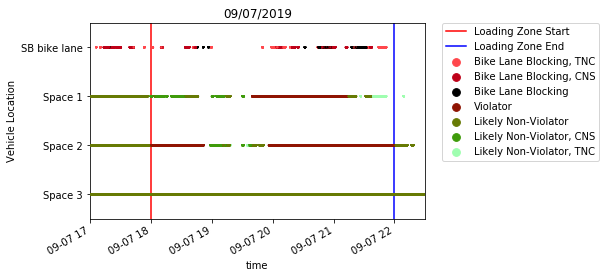

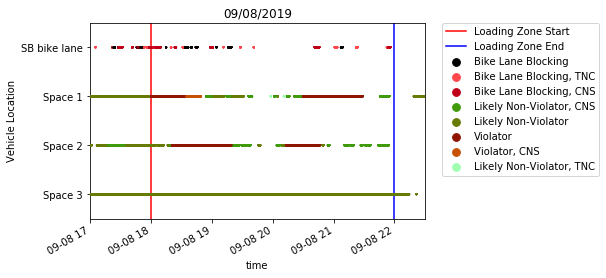

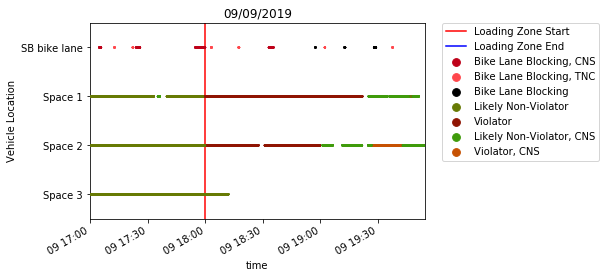

In [159]:
for date in alldays_timestamped['Begin Date'].unique():
    plot(alldays_timestamped[alldays_timestamped['Begin Date'] == date])

In [23]:
def violator_timestamp_table(timestamped_df):
    timestamped_df = timestamped_df[timestamped_df.loc[:, 'Vehicle Location'] != 'Space 3']
    outputdf = pd.DataFrame()
    
    def counts_to_df(counts_series, viol_label, viol_value):
        new_column = str(viol_value) + ' ' + viol_label
        try:
            mask = counts_series.loc[:, viol_label] == viol_value
            df = pd.DataFrame(counts_series.loc[:, viol_label][mask]
                              ).rename(columns={'Violator': new_column})
        except:
            print('index failed', 
                  len(mask), 
                  len(counts_series.loc[:, viol_label]))
            print('lbl:{}, value:{}'.format(viol_label, viol_value))
            #return counts_series, mask
        df[new_column] = 1
        return df
    
    df_grouped = timestamped_df.groupby(level=0)
    viol_counts = df_grouped['Violator'].value_counts()
    viol_labels = timestamped_df['Violator'].unique()
    for label in viol_labels:
        for value in viol_counts.loc[:,label].unique():
            countdf = counts_to_df(viol_counts, label, value)
            if type(countdf) == pd.core.frame.DataFrame:
                outputdf = outputdf.join(countdf, how='outer')
    return outputdf
            #else:
                #debug
                #return countdf

In [24]:
testdf = violator_timestamp_table(alldays_timestamped.loc['2019-08-30 20:45:00':'2019-08-30 21:30:00'])

In [25]:
testdf

,1 Likely Non-Violator,2 Likely Non-Violator,1 Bike Lane Blocking,1 Violator,2 Violator
Timestamp,,,,,
2019-08-30 20:46:00,1.0,NaN,NaN,NaN,NaN
2019-08-30 20:46:01,1.0,NaN,NaN,NaN,NaN
2019-08-30 20:46:02,1.0,NaN,NaN,NaN,NaN
2019-08-30 20:46:03,1.0,NaN,NaN,NaN,NaN
2019-08-30 20:46:04,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-08-30 21:29:56,NaN,NaN,NaN,1.0,NaN
2019-08-30 21:29:57,NaN,NaN,NaN,1.0,NaN
2019-08-30 21:29:58,NaN,NaN,NaN,1.0,NaN


In [27]:
blocked = testdf.dropna(subset=['1 Bike Lane Blocking']).pivot(columns='1 Bike Lane Blocking')

In [28]:
blocked

,1 Likely Non-Violator,2 Likely Non-Violator,1 Violator,2 Violator
1 Bike Lane Blocking,1.0,1.0,1.0,1.0
Timestamp,,,,
2019-08-30 20:47:55,1.0,NaN,NaN,NaN
2019-08-30 20:47:56,1.0,NaN,NaN,NaN
2019-08-30 20:47:57,1.0,NaN,NaN,NaN
2019-08-30 20:47:58,1.0,NaN,NaN,NaN
2019-08-30 20:47:59,1.0,NaN,NaN,NaN
...,...,...,...,...
2019-08-30 21:25:05,NaN,NaN,NaN,1.0
2019-08-30 21:25:06,NaN,NaN,NaN,1.0


In [34]:
blocked.columns

MultiIndex([('1 Likely Non-Violator', 1.0),
            ('2 Likely Non-Violator', 1.0),
            (           '1 Violator', 1.0),
            (           '2 Violator', 1.0)],
           names=[None, '1 Bike Lane Blocking'])

In [17]:
blocked.shape

(499, 4)

In [21]:
blocked.sum()

                      Bike Lane Blocking1
Likely Non-Violator1  1.0                    167.0
Likely Non-Violator2  1.0                      6.0
Violator1             1.0                    190.0
Violator2             1.0                    193.0
dtype: float64

## Home stretch here, support conditionals with col MultiIndex?

In [151]:
plot_everything(alldays_timestamped)

KeyboardInterrupt: 

## Moving Forwards
### short-term
* general speed-up (see Pandas advice, for loops, cython?, weird parallel thing, etc?)
    * Pandas 1.0 should help some too
* loading zone ends at 10pm
* show TNC/CNS activity on plot?
* Scatter/fit line of seconds blocked+seconds any violator?
* send visual/summary package to Juan for city meeting (Google Slides) (draft 1-2wk)

### longer-term
* rewrite to call blocking stats explicitly for each interval, support datetimeindex?
* count # of cars in bike lane, compare to 1 violator, 2 violator 
* --> model counterfactual, bike lane availability under perfect enforcement, (get sizing reccomendation, is 2 enough??, what about if there is no enforcement?? (bigger?) )
* OpenCV (w/ David?)
* interactive visualization tool, summary stats (late Feb?) (goal of project!)
* eventual paper on data/stats
* eventual tool description
